In [1]:
import numpy as np
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_object import *
import mne
from biotuner.harmonic_connectivity import *

pygame 2.1.2 (SDL 2.0.18, Python 3.8.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [58]:
import numpy as np
from biotuner.biotuner_object import compute_biotuner
from biotuner.metrics import ratios2harmsim, compute_subharmonics_2lists, euler
from biotuner.biotuner_utils import rebound_list
from biotuner.peaks_extension import harmonic_fit
import itertools
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from mne.viz import circular_layout
from mne_connectivity.viz import plot_connectivity_circle


class harmonic_connectivity(object):
    """
    Class used to compute harmonicity metrics
    between pairs of sensors.
    """

    def __init__(
        self,
        sf=None,
        data=None,
        peaks_function="EMD",
        precision=0.1,
        n_harm=10,
        harm_function="mult",
        min_freq=2,
        max_freq=80,
        n_peaks=5,
    ):
        """
        Parameters
        ----------
        sf: int
            sampling frequency (in Hz)
        data : 2Darray(elec, numDataPoints)
            Electrodes x Time series to analyse.
        peaks_function: str
            Defaults to 'EMD'.
            See compute_biotuner class for details.
        precision: float
            Defaults to 0.1
            precision of the peaks (in Hz)
            When HH1D_max is used, bins are in log scale.
        n_harm: int
            Defaults to 10.
            Set the number of harmonics to compute in harmonic_fit function
        harm_function: str
            {'mult' or 'div'}
            Defaults to 'mult'
            Computes harmonics from iterative multiplication (x, 2x, 3x, ...nx)
            or division (x, x/2, x/3, ...x/n).
        min_freq: float, optional
            Defaults = 2. Minimum frequency (in Hz) to consider for peak extraction.
        max_freq: float, optional
            Defaults = 80. Maximum frequency (in Hz) to consider for peak extraction.
        n_peaks: int, optional
            Default = 5. Number of peaks to extract per frequency band.

        """
        """Initializing data"""
        if type(data) is not None:
            self.data = data
        self.sf = sf
        """Initializing arguments for peak extraction"""
        self.peaks_function = peaks_function
        self.precision = precision
        self.n_harm = n_harm
        self.harm_function = harm_function
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.n_peaks = n_peaks

    def compute_harm_connectivity(self, metric='harmsim', delta_lim=20,
                                  save=False, savename='_', graph=True):
        # Initialize biotuner object
        self.metric = metric
        data = self.data
        list_idx = list(range(len(data)))
        pairs = list(itertools.product(list_idx, list_idx))
        print(pairs)
        harm_conn_matrix = []
        for pair in pairs:
            data1 = data[pair[0]]
            data2 = data[pair[1]]
            bt1 = compute_biotuner(self.sf, peaks_function=self.peaks_function,
                                   precision=self.precision, n_harm=self.n_harm)
            bt1.peaks_extraction(data1, min_freq=self.min_freq,
                                 max_freq=self.max_freq, max_harm_freq=150,
                                 n_peaks=self.n_peaks, noverlap=None,
                                 nperseg=None, nfft=None, smooth_fft=1)
            list1 = bt1.peaks
            bt2 = compute_biotuner(self.sf, peaks_function=self.peaks_function,
                                   precision=self.precision, n_harm=self.n_harm)
            bt2.peaks_extraction(data2, min_freq=self.min_freq,
                                 max_freq=self.max_freq, max_harm_freq=150,
                                 n_peaks=self.n_peaks, noverlap=None,
                                 nperseg=None, nfft=None, smooth_fft=1)
            list2 = bt2.peaks
            if metric == 'subharm_tension':
                common_subs, delta_t, sub_tension_final, harm_temp, pairs_melody = compute_subharmonics_2lists(list1,
                                                                                                 list2,
                                                                                                 self.n_trans_harm,
                                                                                                 delta_lim=delta_lim,
                                                                                                 c=2.1)
                harm_conn_matrix.append(sub_tension_final)
            # compute the harmonic similarity between each pair of peaks from the two electrodes.
            if metric == 'harmsim':
                harm_pairs = list(itertools.product(list1, list2))
                ratios = []
                for p in harm_pairs:
                    if p[0] > p[1]:
                        ratios.append(p[0]/p[1])
                    if p[1] > p[0]:
                        ratios.append(p[1]/p[0])
                ratios = rebound_list(ratios)
                harm_conn_matrix.append(np.mean(ratios2harmsim(ratios)))

            if metric == 'euler':
                list_all = list1 + list2
                list_all = [int(x*10) for x in list_all]
                harm_conn_matrix.append(euler(*list_all))

            if metric == 'harm_fit':
                harm_pairs = list(itertools.product(list1, list2))
                harm_fit = []
                for p in harm_pairs:
                    a, b, c, d = harmonic_fit([4, 7.6],
                                              n_harm=10,
                                              bounds=0.5,
                                              function="mult",
                                              div_mode="div",
                                              n_common_harms=2)
                    harm_fit.append(len(a))
                harm_conn_matrix.append(np.sum(harm_fit))
        matrix = np.empty(shape=(len(data), len(data)))
        for e, p in enumerate(pairs):
            matrix[p[0]][p[1]] = harm_conn_matrix[e]
        #conn_matrix = matrix.astype('float')
        if graph is True:
            sbn.heatmap(matrix)
            plt.show()
        self.conn_matrix = matrix
        return matrix

    
    def plot_conn_matrix(self, conn_matrix=None, node_names=None):
        if conn_matrix is None:
            conn_matrix = self.conn_matrix
        if node_names is None:
            node_names = range(0, len(conn_matrix), 1)
            node_names = [str(x) for x in node_names]
        fig = plot_connectivity_circle(conn_matrix, node_names=node_names, n_lines=100,
                        fontsize_names=24, show=False, vmin=0.)


## Load dataset

In [2]:
data_L = np.load('data_examples/EEG_pareidolia/parei_occi_L.npy')
data_R = np.load('data_examples/EEG_pareidolia/parei_occi_R.npy')

In [62]:
data = data_L[0:8]

## Compute harmonic connectivity

The comodulogram is a matrix representing the strength of the coupling between the phase of driver frequencies and the amplitude of signal frequencies. The 'pac' method allows to extract pairs of driver/signal frequencies that exhibit higher scores of coupling

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number 

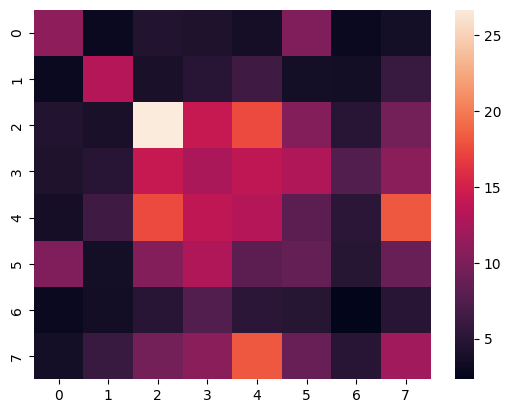

In [63]:
HC = harmonic_connectivity(sf=1000,
        data=data,
        peaks_function="EMD",
        precision=0.1,
        n_harm=10,
        harm_function="mult",
        min_freq=2,
        max_freq=80,
        n_peaks=5)

conn_matrix = HC.compute_harm_connectivity(metric='harmsim', delta_lim=20,
                                  save=False, savename='_', graph=True)

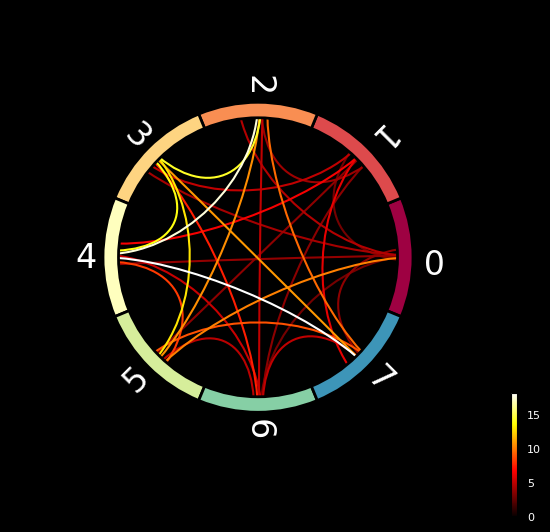

In [64]:

ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4']
positions = [(-0.83, 0.55), (0.83, 0.55), (-1.33, 0.05), (-0.67, 0.05), (0.0, 0.05), (0.67, 0.05), (1.33, 0.05), (-1.58, -0.45), (-0.58, -0.45), (0.0, -0.45), (0.58, -0.45), (1.58, -0.45), (-1.33, -0.95),     (-0.67, -0.95), (0.0, -0.95), (0.67, -0.95)]

#montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, positions)))
#layout = mne.channels.find_layout(montage)

HC.plot_conn_matrix(conn_matrix)